[前回](http://hkwi.github.io/kobe-barcelona/app/2016/09/27/area.html)、神戸市の人口を 3 成分に分解して地図上の区域で塗り分けましたが、どうにも地図として閲覧するのに不自由でした。

Google maps で表示できるように KML で出力します。

In [1]:
import glob
import numpy
import pandas as pd
import geopandas as gpd
import sklearn.decomposition
import matplotlib
from shapely.geometry import Point
from matplotlib import pyplot as plt

環境依存の設定。

In [2]:
%matplotlib inline

データの読み込み。

In [3]:
# load data
ages=["%d歳" % i for i in range(100)]+["100歳以上"]
def load_zensi(fname):
    e = pd.ExcelFile(fname)
    opts = dict(skiprows=1, converters={"区コード":str, "町コード":str})
    dfs = [e.parse(s, **opts).iloc[1:,:] for s in e.sheet_names if s != "神戸市"]
    return pd.DataFrame(pd.concat(dfs, ignore_index=True))

data0 = load_zensi("../data/kobe/zensi2808.xls")

us = [gpd.read_file(f) for f in glob.glob("../data/estat/h22ka281*.shp")]
pib = gpd.GeoDataFrame(pd.concat(us, ignore_index=True), crs=us[0].crs)
pib2 = pib[(pib["MOJI"]!="水面") & (pib["MOJI"].isnull()==False)] # 海上を取り除く

pib2_keycodes = set(pib2["KEYCODE1"])
data1 = data0.assign(KEYCODE1=lambda df:df["町コード"][df["町コード"].isin(pib2_keycodes)])

qname = data0.apply(lambda r:"神戸市 %s %s" % (r["区・支所"].replace("支所",""), r["町名"]), axis=1)
try:
    cache = pd.read_json(open("../cache/kobe.json", encoding="UTF-8")).T
except:
    cache = pd.DataFrame([], columns=["lat", "lng"])

qn = pd.DataFrame(qname, columns=["qname"])
qa = qn[data0["町コード"].isin(set(pib2["KEYCODE1"]))==False].join(cache, on="qname", how="inner")
pt = gpd.GeoDataFrame(qa.apply(lambda r:Point(r["lng"], r["lat"]), axis=1), columns=["geometry"], crs="+init=epsg:4326")
pt_mv = gpd.tools.sjoin(pt, pib2.to_crs("+init=epsg:4326"), op="within")
data1.loc[pt_mv.index, "KEYCODE1"] = pt_mv["KEYCODE1"]

人口データの区域への割り振りと、NMF での成分分解。

In [4]:
area=pd.DataFrame(pib2.geometry.area, index=pib2.index, columns=["AREA_SUM"])
area_sum = pd.DataFrame(pd.concat([area, pib2["KEYCODE1"]], axis=1), columns=["AREA_SUM", "KEYCODE1"]).groupby("KEYCODE1").sum()
pib_ages = data1.groupby("KEYCODE1")[ages].sum()
pib3 = pib2.join(area_sum, on="KEYCODE1").join(pib_ages, on="KEYCODE1")
pib4 = pib3[pib3[ages].isnull().all(axis=1)==False]
pib5 = pib4.loc[:,ages].mul(pib4.geometry.area / pib4["AREA_SUM"], axis=0)

dens = numpy.power(pib2.geometry.area, -1/2) # gamma
dens.name="dens"

cpib = gpd.GeoDataFrame(pd.concat([pib2["geometry"],
    pd.Series(pib2.index, index=pib2.index, name="idx"),
    pd.Series([1]*len(pib2.index), index=pib2.index, name="one")], axis=1))
cpib2 = gpd.tools.sjoin(cpib, cpib, how="left", op="intersects")
f = cpib2.groupby("idx_left").sum()["one_right"]
f.name = "count_right"

cpib3 = cpib2.join(pib5, on="idx_left").join(f, on="idx_left")
cpib4 = cpib3.fillna(0)
cpib5 = (cpib4[ages].T/cpib4["count_right"]).T

bpib = pd.concat([cpib4[["idx_left","idx_right"]], cpib5], axis=1).groupby("idx_right").sum()
bpib2 = cpib.join(bpib, on="idx")

m = sklearn.decomposition.NMF(3)
o = m.fit_transform(bpib2[ages].values)

qv = pd.DataFrame(m.components_.dot([i*2 for i in range(101)]), columns=["sort_key"]).sort_values("sort_key", ascending=False)
cc = ["rbg"[list(qv.index).index(i)] for i in range(m.n_components)]
bc2 = pd.DataFrame(sklearn.preprocessing.normalize(o), index=bpib2.index, columns=cc)
bc3 = pd.concat([bc2,dens], axis=1).apply(lambda r:tuple(
        [r[i] for i in "rgb"] + [0 if r[["r","g","b"]].sum()==0 else min(r["dens"]/0.01*0.9+0.1, 1.0)]
), axis=1)
bc3.name="color"

g = gpd.GeoDataFrame(pd.concat([bpib2["geometry"], pd.Series(range(len(bpib2.index)), index=bpib2.index, name="idx")], axis=1), crs=pib.crs)

地図にプロットして確認します。

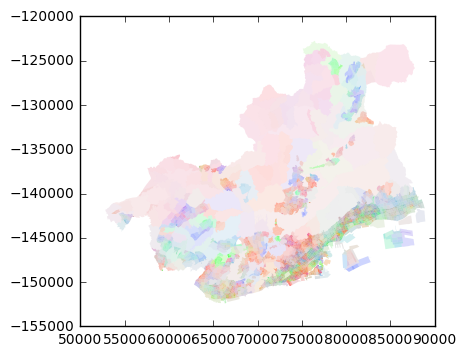

In [5]:
_ = g.plot(column="idx", cmap=matplotlib.colors.ListedColormap(bc3), alpha=None, linewidth=0)

KML を作ります。サイズが大きくなるので、Fusion table を使います。

In [6]:
def kml_coords(r):
    xy = r.geometry.exterior.xy
    return "\n".join(["%f,%f" % (x,y) for x,y in zip(xy[0], xy[1])])

def abgr(r):
    if sum(r[0:2])==0:
        return "00000000"
    return "%02x%02x%02x%02x" % tuple([int(r[i] * 255) for i in (3,2,1,0)])

coords = g.to_crs("+init=epsg:4326").apply(kml_coords, axis=1)
colors = bc3.apply(abgr)

def kmlstr(idx):
    out = '''<?xml version="1.0" encoding="UTF-8"?>
    <kml xmlns="http://www.opengis.net/kml/2.2">
      <Document>
        <name>KmlFile</name>'''

    for ri in idx:
        out += '''
    <Style id="color%d">
    <LineStyle><width>1.0</width></LineStyle>
    <PolyStyle><color>%s</color><colorMode>normal</colorMode></PolyStyle>
    </Style>''' % (ri, colors[ri])
        out += '''
    <Placemark>
    <name>%d %s</name>
    <visibility>1</visibility>
    <styleUrl>#color%d</styleUrl>
    <Polygon>
    <tessellate>1</tessellate>
    <outerBoundaryIs>
      <LinearRing>
        <coordinates>
    %s
        </coordinates>
      </LinearRing>
    </outerBoundaryIs>
    </Polygon>
    </Placemark>''' % (ri, pib2.loc[ri,"MOJI"], ri, coords[ri])

    out+='''</Document></kml>'''
    return out

In [7]:
open("../docs/data/2016-09-28-area.kml","w",encoding="UTF-8").write(kmlstr(pib2.index))

4525875

In [8]:
def rgba(r):
    if sum(r[0:2])==0:
        return "#00000000"
    return "#%02x%02x%02x%02x" % tuple([int(r[i] * 255) for i in (0,1,2,3)])

webcolor = bc3.apply(rgba)
color_csv = "\n".join(["%d %s,%s" % (ri, pib2.loc[ri,"MOJI"], webcolor[ri]) for ri in pib2.index])

In [9]:
open("../docs/data/2016-09-28-colors.csv","w", encoding="UTF-8").write(color_csv)

61987

Google fusion tables 上で[地図に表示して閲覧](https://www.google.com/fusiontables/DataSource?docid=15YS102nCSxKRMTDMD2DpBsFzswH8aZSPh4bMGRSX)できるようにしました。

Google My Map はデータ数が限定されるため、二つに分けないとダメみたいです。

In [10]:
open("../docs/data/2016-09-28-area-west.kml", "w", encoding="UTF-8").write(kmlstr(pib2[pib2["CSS_NAME"].isin(["須磨区","西区","垂水区"])].index))
open("../docs/data/2016-09-28-area-east.kml", "w", encoding="UTF-8").write(kmlstr(pib2[pib2["CSS_NAME"].isin(["須磨区","西区","垂水区"])==False].index))

2759773